In [1]:
import numpy as np
from IPython import display

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
num_hidden = 100
num_dxs = 300
num_findings = 5000
num_samples = 6000

In [4]:
def update_params(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,H_0,Sig_H_0_inv,W_0,Sig_W_0_inv,V_0,Sig_V_0_inv):
    num_samples, num_hidden = H.shape
    _, num_findings = W.shape
    _, num_dxs = V.shape
    
    Xi = np.sqrt(Sig_H.dot(Sig_W+(W**2))+(H**2).dot(Sig_W)+(H.dot(W))**2)
    Eta2 = diff_op(H.dot(V))**2+ diff_op2((Sig_H+H**2).dot(Sig_V))+np.tensordot(Sig_H,diff_op(V)**2,axes=(1,0)) 
    Eta = np.sqrt(Eta2)
    #Eta = np.sqrt(diff_op2(Sig_H.dot(Sig_V+(V**2))+(H**2).dot(Sig_V)+(H.dot(V))**2))
    
    assert np.isfinite(Xi).all()
    assert np.isfinite(Eta).all()
    
    L = lower_marginal_likelihood_bound(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,Xi,Eta,H_0,Sig_H_0_inv,W_0,Sig_W_0_inv,V_0,Sig_V_0_inv)
    
    
    W, Sig_W = update_weights(X,W,H,Xi,W_0,Sig_W_0_inv)
    
    LW = lower_marginal_likelihood_bound(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,Xi,Eta,H_0,Sig_H_0_inv,W_0,Sig_W_0_inv,V_0,Sig_V_0_inv)
    
    diff_op_mat = diff_op(np.eye(V.shape[1]))
    H_ext = np.einsum('ij,klm->ilmjk',H,diff_op_mat).reshape([num_samples,-1])
    V_resh,Sig_V_resh = update_weights(Y.reshape([-1]),
                                       V.reshape([-1]),
                                       H_ext.reshape([-1,len(V.reshape([-1]))]),
                                       Eta.reshape([-1]),
                                       V_0.reshape([-1]),
                                       Sig_V_0_inv.reshape([-1]))
    V = V_resh.reshape(V.shape)
    Sig_V = Sig_V_resh.reshape(V.shape)
    
    LV = lower_marginal_likelihood_bound(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,Xi,Eta,H_0,Sig_H_0_inv,W_0,Sig_W_0_inv,V_0,Sig_V_0_inv)
    
    
    W_ext = np.hstack([W,diff_op(V).reshape([num_hidden,-1])])
    Xi_ext = np.hstack([Xi,Eta.reshape([num_samples,-1])])
    T_ext = np.hstack([X,Y.reshape([num_samples,-1])])
    
    H_T, Sig_H_T = update_weights(T_ext.T,H.T,W_ext.T,Xi_ext.T,H_0.T,Sig_H_0_inv.T)
    H, Sig_H = (H_T.T,Sig_H_T.T)
    
    LH = lower_marginal_likelihood_bound(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,Xi,Eta,H_0,Sig_H_0_inv,W_0,Sig_W_0_inv,V_0,Sig_V_0_inv)
    
    return (H,Sig_H), (W,Sig_W), (V,Sig_V), (L,LW,LV,LH)

def update_weights(T,W,X,Xi,W_0,S_W_0_inv):
    """Update the weight matrix
    T = observed values
    W = weights (at current iteration of VB)
    X = features
    Xi = JJ positions (at current iteration of VB)
    W_0 = prior bias for W
    reg = regularization strength
    
    we assume T ~ Bernouilli(sigmoid(XW))
    returns (W,Sig_W)
    where W are the updated weight values and Sig_W are the current variances of those weight values.
    """
    #print("T: %s, W: %s, X: %s, Xi: %s, W_0: %s" % (T.shape,W.shape,X.shape,Xi.shape,W_0.shape))
    k = (len(X.shape)+len(W.shape)-len(T.shape))//2 # number of indices to contract over.
    #S_W_0_inv = reg*np.ones(W.shape)
    
    assert np.isfinite(Xi).all()
    lamXi = lambdoid(Xi)
    assert np.isfinite(lamXi).all()
    
    #print("k:%d, X: %s, Xi: %s" %(k,X.shape,Xi.shape))
    X2lamXi = np.tensordot((X**2).T,lamXi,k)
    assert np.isfinite(X2lamXi).all()
    
    S_W_inv_ = S_W_0_inv + 2*X2lamXi
    S_W_ = np.reciprocal(S_W_inv_)
    assert np.isfinite(S_W_).all()
    
    term1 = np.tensordot(X.T, T-0.5-2*lamXi*np.tensordot(X,W,k),k)
    term2 = 2*W*X2lamXi
    
    assert np.isfinite(term1).all()
    assert np.isfinite(term2).all()
    
    W_ = S_W_*(S_W_0_inv*W_0+term1+term2)
    
    assert np.isfinite(W_).all()
    return W_, S_W_
    

In [5]:
def diff_op(HV,max_dxs=None):
    return np.tile(HV[:,:,np.newaxis],[1,1,num_dxs])-np.tile(HV[:,np.newaxis,:],[1,num_dxs,1])

def diff_op2(HV,max_dxs=None):
    return np.tile(HV[:,:,np.newaxis],[1,1,num_dxs])+np.tile(HV[:,np.newaxis,:],[1,num_dxs,1])
    
def diff_op_T(HTY):
    return HTY.sum(axis=2)-HTY.sum(axis=1)

In [6]:
HV = np.random.normal(size=[num_samples,num_dxs])
HVV = diff_op(HV)

In [7]:
HV

array([[-0.6526017 ,  1.54077392, -0.65260275, ...,  0.68227062,
         2.03675872,  0.19961858],
       [ 1.71072553,  0.52430054, -0.21793538, ...,  0.4315036 ,
        -0.0707377 ,  0.15055403],
       [-0.88685874, -0.11229165, -0.87423572, ..., -0.88335287,
        -0.4867654 , -0.46816765],
       ..., 
       [-1.48014547, -0.23079999, -2.51427556, ...,  1.15235457,
        -0.82339672,  0.72965151],
       [ 0.19132085,  2.51516295, -1.3517964 , ..., -0.0916454 ,
         0.21066786,  0.14151658],
       [ 1.08015848,  0.63971218, -0.64354909, ..., -0.18513993,
        -0.89264627,  0.84298275]])

In [60]:
HV = np.random.randint(low=-5,high=5,size=[num_samples,num_dxs])
HVV = diff_op(HV)
for k in range(num_samples):
    for i in range(num_dxs):
        for j in range(num_dxs):
            if i==j:
                assert(HVV[k,i,j]==0)
            else:
                assert(HVV[k,i,j]==HV[k,i]-HV[k,j])

HTY = np.random.randint(low=-5,high=5,size=[num_samples,num_dxs,num_dxs])
HHTY = diff_op_T(HTY)
assert((np.einsum('ijk,pjk->ip',HVV,HTY)==HV.dot(HHTY.T)).all())

KeyboardInterrupt: 

In [8]:
def KLDivergence(m1,Sig1,m2,Sig2):
    """Computes the KL divergence of two multivariate normal distributions. 
    mi and Sigi are the respective means and covariance matrices"""
    d = len(m1)
    Sig2inv = np.linalg.inv(Sig2)
    Sig2invSig1 = Sig2inv.dot(Sig1)
    return 0.5*(-np.linalg.slogdet(Sig2invSig1)[1]-d+np.trace(Sig2invSig1)+(m2-m1).T.dot(Sig2inv.dot(m2-m1)))

def KLDivergence_diag(m1,Sig1,m2,Sig2):
    """Computes the KL divergence of two multivariate normal distributions. 
    mi and Sigi are the respective means and covariance matrices"""
    d = len(m1.flatten())
    Sig2inv = np.reciprocal(Sig2)
    Sig2invSig1 = Sig2inv*Sig1
    return 0.5*(-np.log(Sig2invSig1).sum()-d+Sig2invSig1.sum()+(((m2-m1)**2)*Sig2inv).sum())

In [9]:
def log_1_add_exp(x):
    mask = x<0
    nmask = np.logical_not(mask)
    ans = np.zeros_like(x)
    ans[mask] = np.log1p(np.exp(x[mask]))
    ans[nmask] = np.log1p(np.exp(-x[nmask]))+x[nmask]
    return ans

def lower_marginal_likelihood_bound(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,Xi,Eta,H_0,Sig_H_0_inv,W_0,Sig_W_0_inv,V_0,Sig_V_0_inv):
    KLH = KLDivergence_diag(H,Sig_H,H_0,np.reciprocal(Sig_H_0_inv))
    KLW = KLDivergence_diag(W,Sig_W,W_0,np.reciprocal(Sig_W_0_inv))
    KLV = KLDivergence_diag(V,Sig_V,V_0,np.reciprocal(Sig_V_0_inv))
    HW = H.dot(W)
    HW2 = Sig_H.dot(Sig_W+W**2)+(H**2).dot(Sig_W)+HW**2
    lamXi = lambdoid(Xi)
    lseW = (lamXi*(HW2-Xi**2)+0.5*(HW-Xi)+log_1_add_exp(Xi)).sum()
    HVF = diff_op(H.dot(V))
    HVF2 = diff_op2(Sig_H.dot(Sig_V+V**2)+(H**2).dot(Sig_V))+HVF**2 
    lamEta = lambdoid(Eta)
    lseV = (lamEta*(HVF2-Eta**2)+0.5*(HVF-Eta)+log_1_add_exp(Eta)).sum()
    e_log_likelihood = (X*HW).sum()+(Y*HVF).sum()-lseW-lseV
    return KLH+KLW+KLV-e_log_likelihood

In [10]:
def lambdoid(xi):
    from scipy.special import exprel
    xi = -abs(xi)
    return 0.25*exprel(xi)/(np.exp(xi)+1)

In [11]:
def sigmoid(eta):
    return 1/(1+np.exp(-eta))

In [12]:
_W = np.random.randn(num_dxs, num_findings)

In [13]:
def bernoulli(p):
    rands = np.random.rand(*np.array(p).shape)
    return np.array(rands < p,dtype=np.float)

In [14]:
def generate_cases(num_dxs, num_findings, avg_ddx_length, w, num_samples=1):
    h = np.random.randn(num_samples,num_dxs)
    y = bernoulli(sigmoid(diff_op(h)))
    x = bernoulli(sigmoid(h.dot(w)))
    return x,y,h

In [15]:
X,Y,H_0 = generate_cases(num_dxs=num_dxs, num_findings=num_findings, w=_W, avg_ddx_length=1, num_samples=num_samples)

In [16]:
alpha = .1
reg_p = 2
fig = plt.figure(1)
def fit(X, Y, num_hidden, reg_p, alpha):
    num_samples, num_findings = X.shape
    num_dxs = Y.shape[1]
    H_0_ = np.random.randn(num_samples, num_hidden)/np.sqrt(float(num_samples+num_hidden))
    W_0_ = np.random.randn(num_hidden, num_findings)/np.sqrt(float(num_hidden+num_findings))
    V_0_ = np.random.randn(num_hidden, num_dxs)/np.sqrt(float(num_hidden+num_dxs*num_dxs))
    H = np.copy(H_0_)
    W = np.copy(W_0_)
    V = np.copy(V_0_)
    Sig_H_0_inv = 0.01*np.ones(H.shape)
    Sig_W_0_inv = 0.01*np.ones(W.shape)
    Sig_V_0_inv = 0.01*np.ones(V.shape)
    Sig_H = np.reciprocal(Sig_H_0_inv)
    Sig_W = np.reciprocal(Sig_W_0_inv)
    Sig_V = np.reciprocal(Sig_V_0_inv)
    max_h = [abs(H).max()]
    max_w = [abs(W).max()]
    max_v = [abs(V).max()]
    L = []
    for i in range(500):
        (HH, Sig_H), (WW,Sig_W), (VV,Sig_V), Ls = update_params(X,Y,H,Sig_H,W,Sig_W,V,Sig_V,
                                                                H_0_,Sig_H_0_inv,W_0_,Sig_W_0_inv,V_0_,Sig_V_0_inv)
        H = H*(1-alpha) + alpha*HH
        W = W*(1-alpha) + alpha*WW
        V = V*(1-alpha) + alpha*VV
        max_h.append(abs(H).max())
        max_w.append(abs(W).max())
        max_v.append(abs(V).max())
        L += list(Ls)
        #print("iteration %d" % i)
        
        clip = 100000.
        plt.gcf().clf()
        plt.gcf().suptitle("iteration: %d" % i)
        plt.subplot(121)
        plt.plot(range(len(L)),map(lambda x: min(x,clip), L))
        data_h = H_0.dot(_W).flatten()
        data_v = H_0.flatten()
        pred_h = H.dot(W).flatten()
        pred_v = H.dot(V).flatten()
        plt.subplot(222)
        plt.scatter(data_h,pred_h)
        plt.subplot(224)
        plt.scatter(data_v,pred_v)
        display.clear_output(wait=True)
        display.display(plt.gcf()) 
        alpha = np.sqrt(i+1.)*alpha/np.sqrt(i+2.)
    return (H, Sig_H), (W,Sig_W), (V,Sig_V), max_h, max_w, max_v, L

In [ ]:
(H, Sig_H), (W,Sig_W), (V,Sig_V), max_h, max_w, max_v, Ls = fit(X, Y, num_hidden,.1,alpha)

ValueError: x and y must be the same size

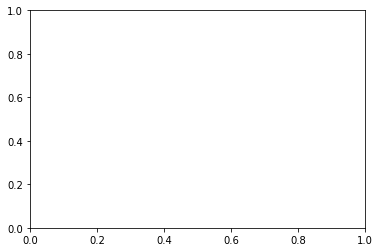

In [50]:
plt.scatter(H.dot(W).flatten(),X.flatten())

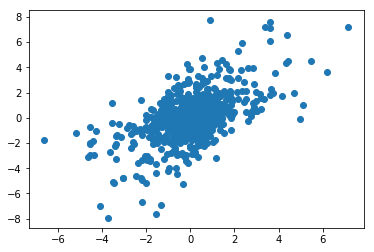

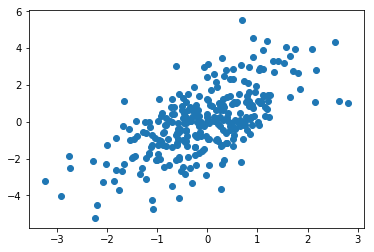

In [24]:
data_h = H_0.dot(_W).flatten()
data_v = H_0.flatten()
pred_h = H.dot(W).flatten()
pred_v = H.dot(V).flatten()
plt.scatter(data_h,pred_h)
plt.show()
plt.scatter(data_v,pred_v)

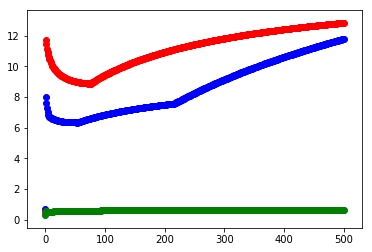

In [25]:
plt.scatter(range(len(max_h)),max_w, color='blue')
plt.scatter(range(len(max_h)),max_v, color='red')
plt.scatter(range(len(max_h)),max_h, color='green')

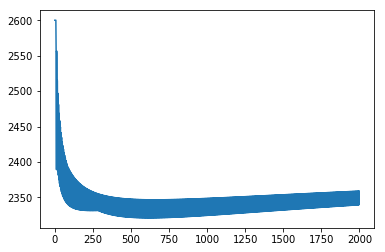

In [31]:
n=-1
clip = 2600.
plt.plot(range(len(Ls[:n])),map(lambda x:min(x,clip),Ls[:n]))